Analyzing stocks: 100%|██████████| 500/500 [00:16<00:00, 31.06it/s]


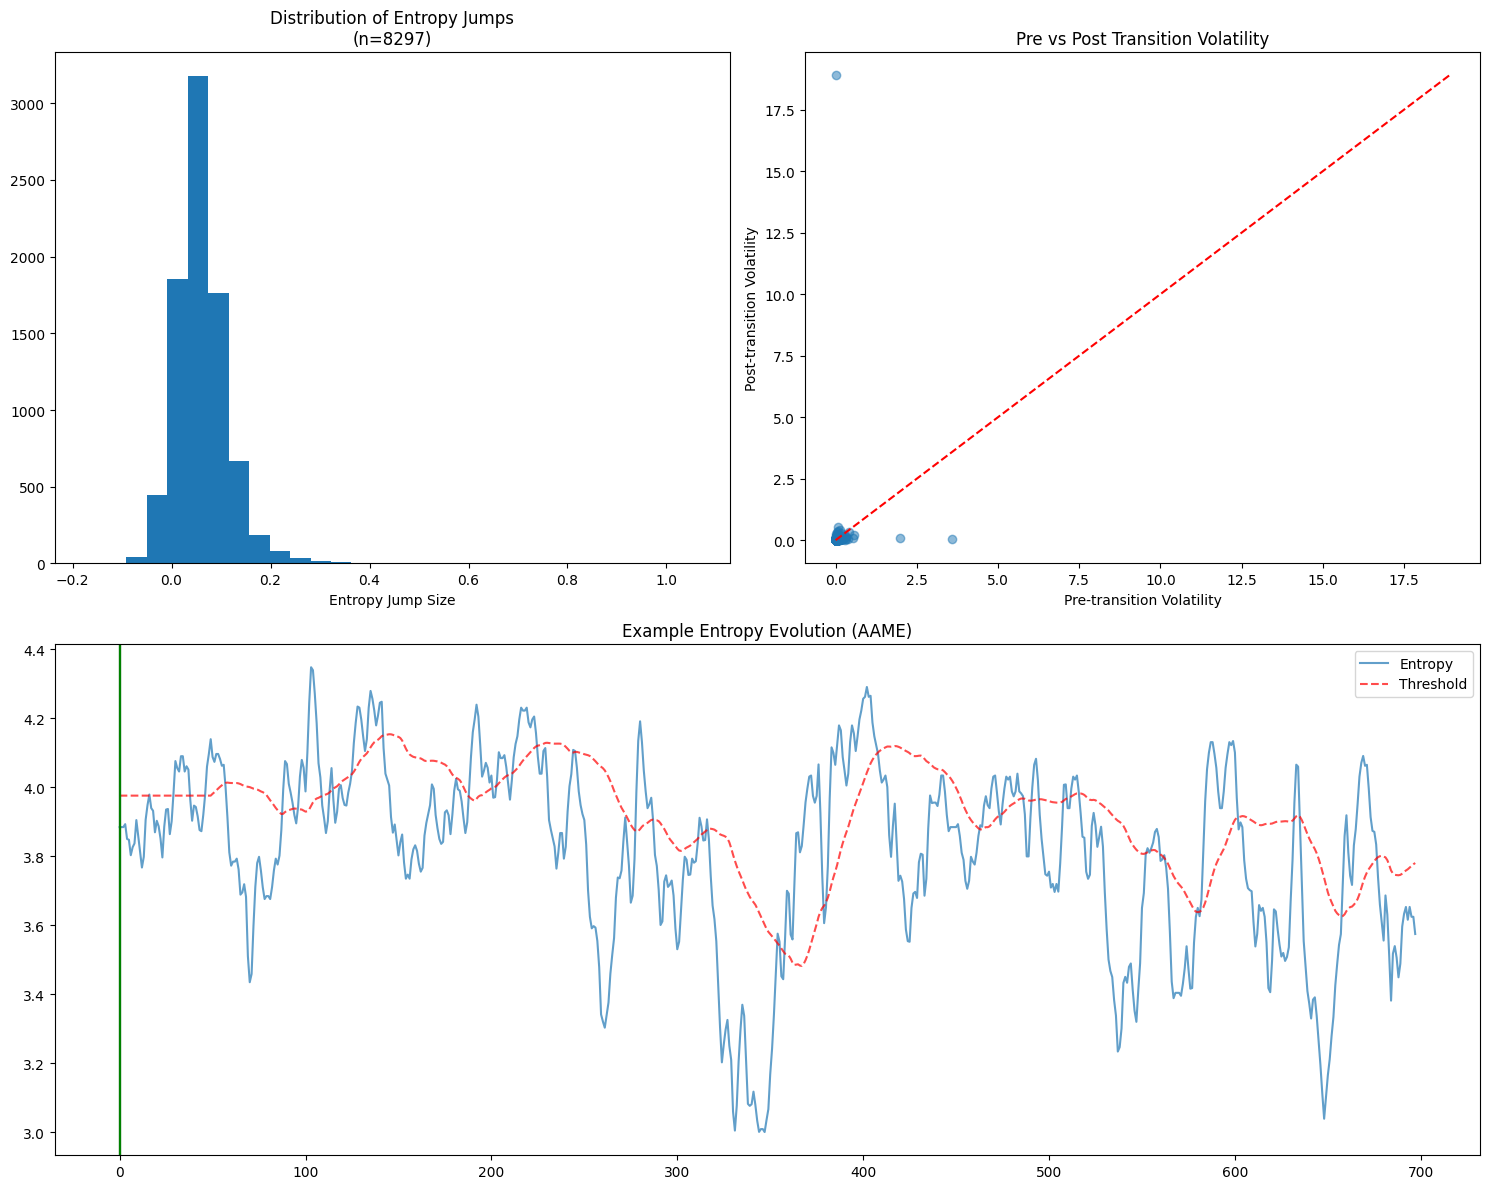


Analysis Results:
--------------------------------------------------
Total stocks analyzed: 500
Stocks with transitions: 500
Total transitions detected: 8297
Average transitions per stock: 16.59
Average volatility ratio (post/pre): infx
Average entropy jump: 0.059

Transition Pattern Statistics:
--------------------------------------------------
       pre_volatility  post_volatility  entropy_jump  volatility_ratio  \
count     8297.000000      8297.000000   8297.000000       8296.000000   
mean         0.028213         0.029135      0.059070               inf   
std          0.050422         0.208284      0.055405               NaN   
min          0.000000         0.000000     -0.173827          0.013150   
25%          0.013919         0.013786      0.025714          0.748215   
50%          0.021638         0.021071      0.048193          0.981481   
75%          0.034626         0.033847      0.082857          1.296145   
max          3.572277        18.891383      1.066185       

In [3]:
import pandas as pd
import numpy as np
from scipy import stats, signal
import glob
import os
from typing import Tuple, Dict
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

class AdaptiveEntropyAnalyzer:
    def __init__(self, window_size: int = 50, smoothing_window: int = 3):
        self.window_size = window_size
        self.smoothing_window = smoothing_window
        
    def calculate_entropy(self, data: np.array, bins: int = 100) -> float:
        """Calculate Shannon entropy of the data"""
        hist, _ = np.histogram(data, bins=bins)
        hist = hist[hist > 0]
        probs = hist / hist.sum()
        return -np.sum(probs * np.log2(probs))
    
    def calculate_adaptive_threshold(self, entropy_series: np.array, 
                                  lookback: int = 50) -> np.array:
        """Calculate adaptive threshold using rolling statistics"""
        rolling_mean = pd.Series(entropy_series).rolling(lookback).mean()
        rolling_std = pd.Series(entropy_series).rolling(lookback).std()
        
        # More sensitive threshold - using 0.5 std instead of 1.5
        threshold = rolling_mean + 0.5 * rolling_std
        
        # Fill initial NaN values with first valid threshold
        threshold = threshold.fillna(method='bfill')
        return threshold.values

    def analyze_stock(self, returns: np.array) -> Tuple[np.array, Dict]:
        """Analyze a single stock's entropy patterns"""
        # Calculate rolling entropy
        entropy_values = []
        for i in range(len(returns) - self.window_size + 1):
            window_data = returns[i:i+self.window_size]
            entropy = self.calculate_entropy(window_data)
            entropy_values.append(entropy)
        
        entropy_series = np.array(entropy_values)
        smoothed_entropy = signal.savgol_filter(entropy_series, 
                                              self.smoothing_window, 3)
        
        # Calculate adaptive threshold
        threshold = self.calculate_adaptive_threshold(smoothed_entropy)
        
        # Identify zones - now using crossovers instead of pure threshold
        entropy_diff = np.diff(smoothed_entropy)
        threshold_diff = np.diff(threshold)
        
        # Identify significant entropy increases
        transition_points = np.where(
            (entropy_diff > np.std(entropy_diff)) & 
            (smoothed_entropy[1:] > threshold[1:])
        )[0]
        
        # Filter out transitions too close to each other
        min_distance = self.window_size
        filtered_transitions = []
        for i, point in enumerate(transition_points):
            if i == 0 or point - filtered_transitions[-1] >= min_distance:
                filtered_transitions.append(point)
        
        transitions = np.array(filtered_transitions)
        
        # Analyze zones
        zones = self._analyze_zones(returns, smoothed_entropy, transitions)
        
        return smoothed_entropy, threshold, zones
    
    def _analyze_zones(self, returns: np.array, entropy: np.array,
                      transition_points: np.array) -> Dict:
        """Analyze characteristics of different entropy zones"""
        zones = {
            'transitions': []
        }
        
        for point in transition_points:
            if point - self.window_size >= 0 and point + self.window_size < len(returns):
                transition = self._analyze_transition(
                    returns[point-self.window_size:point+self.window_size],
                    entropy[point-self.window_size:point+self.window_size],
                    point
                )
                zones['transitions'].append(transition)
        
        return zones
    
    def _analyze_transition(self, returns: np.array, entropy: np.array,
                          transition_point: int) -> Dict:
        """Analyze characteristics around transition point"""
        mid = len(returns) // 2
        pre_returns = returns[:mid]
        post_returns = returns[mid:]
        
        return {
            'pre_volatility': np.std(pre_returns),
            'post_volatility': np.std(post_returns),
            'entropy_jump': entropy[mid] - entropy[mid-1],
            'volatility_ratio': np.std(post_returns) / np.std(pre_returns),
            'pre_autocorr': pd.Series(pre_returns).autocorr(),
            'post_autocorr': pd.Series(post_returns).autocorr(),
            'jump_magnitude': np.abs(post_returns[0] - pre_returns[-1])
        }

def analyze_market_patterns():
    """Main analysis function"""
    # Load data
    data_path = 'Data/PriceData'
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    # Initialize analyzer
    analyzer = AdaptiveEntropyAnalyzer(window_size=20, smoothing_window=5)
    
    # Analyze all stocks
    results = {}
    transition_patterns = []
    
    for file in tqdm(parquet_files[:500], desc="Analyzing stocks"):  # Limit to 500 stocks for testing
        try:
            symbol = os.path.basename(file).replace('.parquet', '')
            df = pd.read_parquet(file)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
            
            if len(df) < 252:  # Skip if less than 1 year of data
                continue
                
            returns = df['Close'].pct_change().dropna().values
            entropy, threshold, zones = analyzer.analyze_stock(returns)
            
            results[symbol] = {
                'entropy': entropy,
                'threshold': threshold,
                'zones': zones
            }
            
            # Collect transition patterns
            for transition in zones['transitions']:
                transition['symbol'] = symbol
                transition_patterns.append(transition)
                
        except Exception as e:
            print(f"Error processing {symbol}: {str(e)}")
    
    # Convert to DataFrame for analysis
    pattern_df = pd.DataFrame(transition_patterns)
    
    # Calculate statistics
    stats = {
        'total_stocks': len(results),
        'stocks_with_transitions': len(pattern_df['symbol'].unique()),
        'total_transitions': len(pattern_df),
        'avg_transitions_per_stock': len(pattern_df) / len(results) if results else 0,
        'avg_volatility_ratio': pattern_df['volatility_ratio'].mean() if not pattern_df.empty else 0,
        'avg_entropy_jump': pattern_df['entropy_jump'].mean() if not pattern_df.empty else 0
    }
    
    # Plot results
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Distribution of entropy jumps
    plt.subplot(221)
    if not pattern_df.empty:
        plt.hist(pattern_df['entropy_jump'], bins=30)
        plt.title(f'Distribution of Entropy Jumps\n(n={len(pattern_df)})')
        plt.xlabel('Entropy Jump Size')
    
    # Plot 2: Pre vs Post Volatility
    plt.subplot(222)
    if not pattern_df.empty:
        plt.scatter(pattern_df['pre_volatility'], pattern_df['post_volatility'], alpha=0.5)
        max_vol = max(pattern_df['pre_volatility'].max(), pattern_df['post_volatility'].max())
        plt.plot([0, max_vol], [0, max_vol], 'r--')
        plt.title('Pre vs Post Transition Volatility')
        plt.xlabel('Pre-transition Volatility')
        plt.ylabel('Post-transition Volatility')
    
    # Plot 3: Example stock
    plt.subplot(212)
    if results:
        example_symbol = list(results.keys())[0]
        example_data = results[example_symbol]
        plt.plot(example_data['entropy'], label='Entropy', alpha=0.7)
        plt.plot(example_data['threshold'], 'r--', label='Threshold', alpha=0.7)
        
        # Mark transitions
        transitions = example_data['zones']['transitions']
        for t in transitions:
            plt.axvline(x=t['transition_point'] if 'transition_point' in t else 0, 
                       color='g', alpha=0.3)
        
        plt.title(f'Example Entropy Evolution ({example_symbol})')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results, pattern_df, stats

if __name__ == "__main__":
    results, patterns, statistics = analyze_market_patterns()
    
    print("\nAnalysis Results:")
    print("-" * 50)
    print(f"Total stocks analyzed: {statistics['total_stocks']}")
    print(f"Stocks with transitions: {statistics['stocks_with_transitions']}")
    print(f"Total transitions detected: {statistics['total_transitions']}")
    print(f"Average transitions per stock: {statistics['avg_transitions_per_stock']:.2f}")
    print(f"Average volatility ratio (post/pre): {statistics['avg_volatility_ratio']:.2f}x")
    print(f"Average entropy jump: {statistics['avg_entropy_jump']:.3f}")
    
    if not patterns.empty:
        print("\nTransition Pattern Statistics:")
        print("-" * 50)
        print(patterns.describe())

Analyzing LZ Complexity: 100%|██████████| 500/500 [00:03<00:00, 125.30it/s]


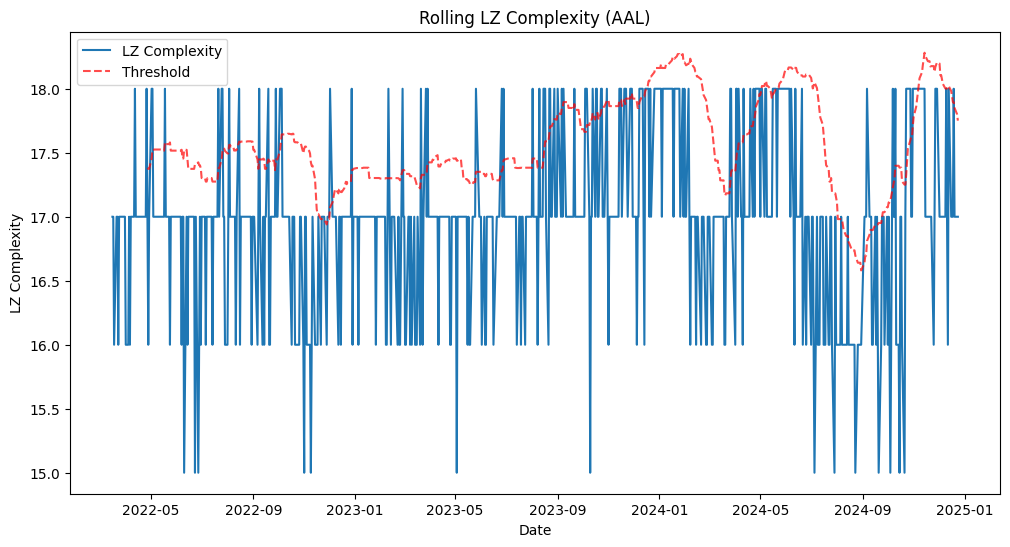

In [3]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------ LZ complexity helpers from above ------
def compute_lz_complexity(trit_seq) -> int:
    mapping = { -1: 'n', 0: '0', 1: 'p' }
    s = ''.join(mapping[x] for x in trit_seq)

    seen_substrings = set()
    complexity_count = 0
    current_substr = ""

    for char in s:
        new_substr = current_substr + char
        if new_substr not in seen_substrings:
            complexity_count += 1
            seen_substrings.add(new_substr)
            current_substr = ""
        else:
            current_substr = new_substr
    return complexity_count


def compute_daily_trits(close_prices: np.array) -> np.array:
    diffs = np.diff(close_prices)
    trits = np.zeros_like(diffs, dtype=int)
    
    trits[diffs > 0] = 1
    trits[diffs < 0] = -1
    return trits


def rolling_lz_complexity(trits: np.array, window: int = 50) -> np.array:
    complexities = []
    for i in range(len(trits) - window + 1):
        window_seq = trits[i : i + window]
        cplx = compute_lz_complexity(window_seq)
        complexities.append(cplx)
    return np.array(complexities)


def analyze_stocks_with_lz(data_path='Data/PriceData', window=50):
    # Grab all parquet files
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    
    # We'll store results in a dict: {symbol -> LZ series, etc.}
    results = {}
    
    # Just as an example limit, or remove it to do all
    for file in tqdm(parquet_files[:500], desc="Analyzing LZ Complexity"):
        symbol = os.path.basename(file).replace('.parquet', '')
        
        try:
            df = pd.read_parquet(file)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date').reset_index(drop=True)
            
            if len(df) < (window + 1):
                continue
            
            closes = df['Close'].values
            trits = compute_daily_trits(closes)
            
            if len(trits) < window:
                continue
            
            # Rolling LZ complexity
            lz_series = rolling_lz_complexity(trits, window=window)
            
            # Optionally compute a threshold
            # e.g. rolling mean + 1 stdev over the LZ time series
            lz_pd = pd.Series(lz_series)
            rolling_mean = lz_pd.rolling(30).mean()
            rolling_std = lz_pd.rolling(30).std()
            threshold = rolling_mean + rolling_std
            
            # Store results
            results[symbol] = {
                'lz_complexity': lz_series,
                'dates': df['Date'].iloc[window:].values,  # align with lz_series
                'threshold': threshold.values
            }
            
        except Exception as e:
            print(f"Error processing {symbol}: {e}")
    
    # Return everything for further EDA
    return results


def main_lz_analysis():
    # Run the analysis
    results = analyze_stocks_with_lz(window=50)
    
    # Example: pick one symbol from results to plot
    if results:
        example_symbol = list(results.keys())[0]
        data = results[example_symbol]
        lz_vals = data['lz_complexity']
        threshold = data['threshold']
        dates = data['dates']
        
        plt.figure(figsize=(12, 6))
        plt.plot(dates, lz_vals, label='LZ Complexity')
        plt.plot(dates, threshold, 'r--', alpha=0.7, label='Threshold')
        plt.title(f"Rolling LZ Complexity ({example_symbol})")
        plt.xlabel("Date")
        plt.ylabel("LZ Complexity")
        plt.legend()
        plt.show()
    
    return results

if __name__ == "__main__":
    all_results = main_lz_analysis()


Analyzing LZ Complexity across Market: 100%|██████████| 5473/5473 [01:02<00:00, 87.23it/s] 


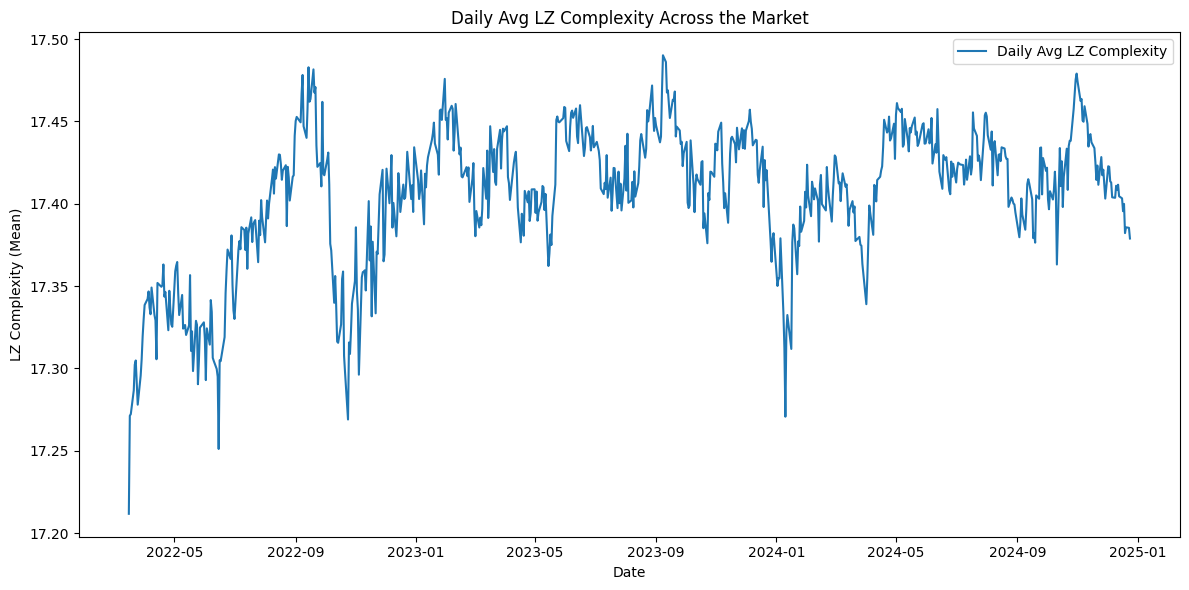

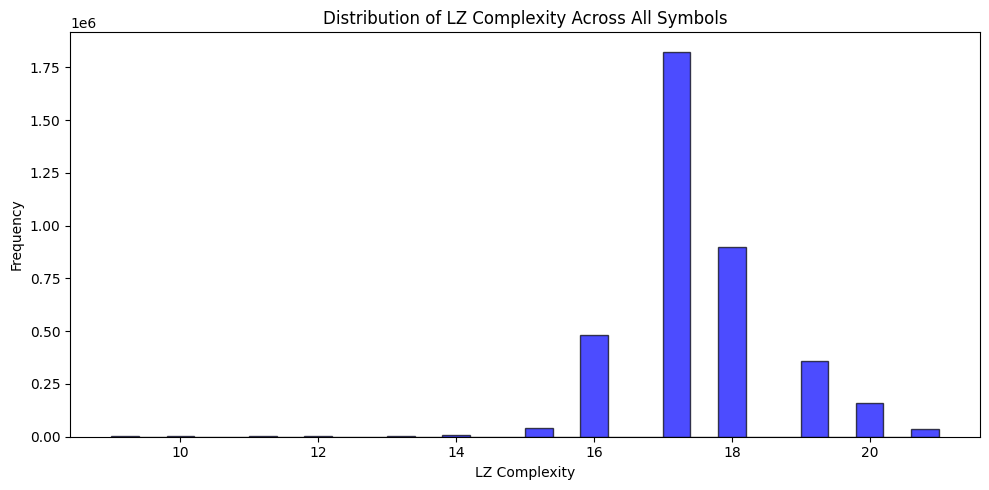

Basic Stats on LZ Complexity (Entire Market)
count    3.823020e+06
mean     1.740490e+01
std      1.156128e+00
min      9.000000e+00
25%      1.700000e+01
50%      1.700000e+01
75%      1.800000e+01
max      2.100000e+01
Name: LZ_Complexity, dtype: float64


In [4]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# ------ LZ complexity helpers ------
def compute_lz_complexity(trit_seq) -> int:
    """
    Compute the Lempel-Ziv complexity for a ternary sequence 
    given as [-1, 0, +1].
    """
    # Map -1 -> 'n', 0 -> '0', +1 -> 'p' to form a string
    mapping = { -1: 'n', 0: '0', 1: 'p' }
    s = ''.join(mapping[x] for x in trit_seq)

    seen_substrings = set()
    complexity_count = 0
    current_substr = ""

    for char in s:
        new_substr = current_substr + char
        if new_substr not in seen_substrings:
            complexity_count += 1
            seen_substrings.add(new_substr)
            current_substr = ""
        else:
            current_substr = new_substr
    return complexity_count


def compute_daily_trits(close_prices: np.array) -> np.array:
    """
    Convert close prices to a ternary direction array of [-1, 0, +1].
    """
    diffs = np.diff(close_prices)
    trits = np.zeros_like(diffs, dtype=int)
    
    trits[diffs > 0] = 1
    trits[diffs < 0] = -1
    return trits


def rolling_lz_complexity(trits: np.array, window: int = 50) -> np.array:
    """
    Compute LZ complexity in a rolling window of size `window`.
    Returns an array of LZ complexity values, one for each valid window.
    """
    complexities = []
    for i in range(len(trits) - window + 1):
        window_seq = trits[i : i + window]
        cplx = compute_lz_complexity(window_seq)
        complexities.append(cplx)
    return np.array(complexities)


def analyze_entire_market_lz(data_path='Data/PriceData', window=50):
    """
    Compute rolling LZ complexity for each stock in data_path,
    then aggregate results across the entire market.
    """
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    all_dfs = []  # we'll collect (Date, Symbol, LZ) data here
    
    for file in tqdm(parquet_files, desc="Analyzing LZ Complexity across Market"):
        symbol = os.path.basename(file).replace('.parquet', '')
        
        try:
            df = pd.read_parquet(file)
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date').reset_index(drop=True)
            
            if len(df) < (window + 1):
                continue
            
            closes = df['Close'].values
            trits = compute_daily_trits(closes)
            
            if len(trits) < window:
                continue
            
            # Rolling LZ complexity
            lz_series = rolling_lz_complexity(trits, window=window)
            
            # The LZ array aligns to df indices from `window` onward
            valid_dates = df['Date'].iloc[window:].values  # same length as lz_series
            
            # Build a small DataFrame for this symbol
            tmp_df = pd.DataFrame({
                'Date': valid_dates,
                'Symbol': symbol,
                'LZ_Complexity': lz_series
            })
            all_dfs.append(tmp_df)
            
        except Exception as e:
            print(f"Error processing {symbol}: {e}")
    
    if not all_dfs:
        print("No data frames collected. Possibly no valid stocks with enough data.")
        return pd.DataFrame()
    
    # Concatenate all partial DataFrames into one big table
    market_df = pd.concat(all_dfs, ignore_index=True)
    return market_df


def main_market_analysis(window=50):
    """
    High-level function to compute LZ across entire market,
    then do some basic EDA/plots on the aggregated data.
    """
    market_df = analyze_entire_market_lz(data_path='Data/PriceData', window=window)
    if market_df.empty:
        print("No results to analyze.")
        return
    
    # 1) Let's compute daily average LZ complexity across the entire market
    #    That means group by Date, then compute mean (or median).
    daily_market_lz = (market_df
                       .groupby('Date')['LZ_Complexity']
                       .mean()
                       .reset_index(name='Avg_LZ'))
    
    # 2) Plot the daily average LZ over time
    plt.figure(figsize=(12, 6))
    plt.plot(daily_market_lz['Date'], daily_market_lz['Avg_LZ'], label='Daily Avg LZ Complexity')
    plt.title("Daily Avg LZ Complexity Across the Market")
    plt.xlabel("Date")
    plt.ylabel("LZ Complexity (Mean)")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3) Distribution of LZ across the entire dataset
    #    Maybe a histogram of all LZ values from all symbols.
    plt.figure(figsize=(10, 5))
    plt.hist(market_df['LZ_Complexity'], bins=30, alpha=0.7, color='blue', edgecolor='k')
    plt.title("Distribution of LZ Complexity Across All Symbols")
    plt.xlabel("LZ Complexity")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # 4) Example: We can also look at a boxplot for LZ complexities grouped by some date ranges,
    #    or simply do a quick describe:
    print("Basic Stats on LZ Complexity (Entire Market)")
    print(market_df['LZ_Complexity'].describe())
    
    # Optionally, return the aggregated data for further analysis
    return market_df, daily_market_lz


if __name__ == "__main__":
    # Let’s pick a window size of 50 bars:
    all_results_df, daily_agg_df = main_market_analysis(window=50)
    
    # Now 'all_results_df' has columns [Date, Symbol, LZ_Complexity],
    # and 'daily_agg_df' has the market-level average by date.


Loading parquet files: 100%|██████████| 5473/5473 [00:05<00:00, 965.86it/s] 


Top 10 Stocks that match market pattern most often:
Symbol
ASCIX     0.967914
VCRRX     0.967914
XSIAX     0.967914
LARAX     0.967914
FXE       0.967914
CADCX     0.967914
CPRDX     0.967914
NCZ-PA    0.967914
FXC       0.967914
FNVT      0.967914
Name: MatchesMarket, dtype: float64

Bottom 10 Stocks that match market pattern least often:
Symbol
ARBK    0.239305
CIFR    0.236631
BTBT    0.232620
BSGM    0.229947
HUT     0.227273
PRCH    0.219251
EOSE    0.216578
IREN    0.213904
WULF    0.209893
KOLD    0.192513
Name: MatchesMarket, dtype: float64


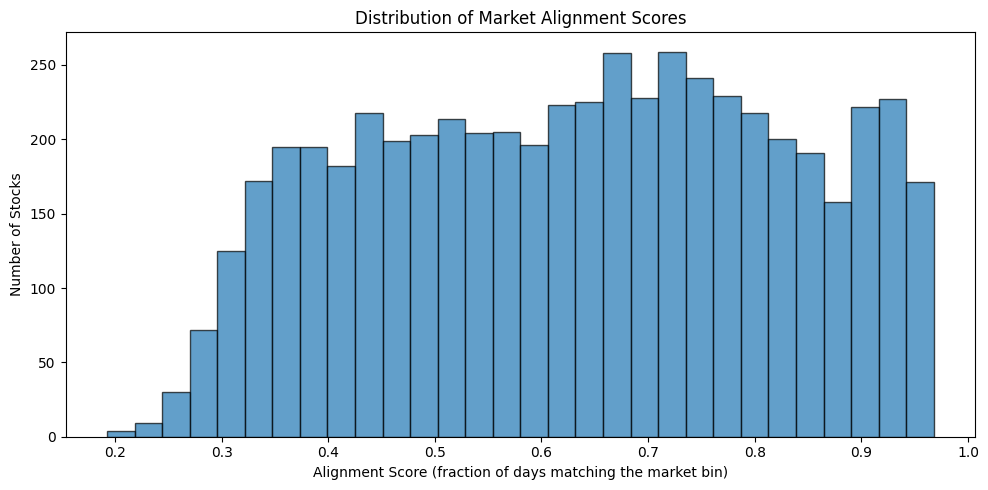

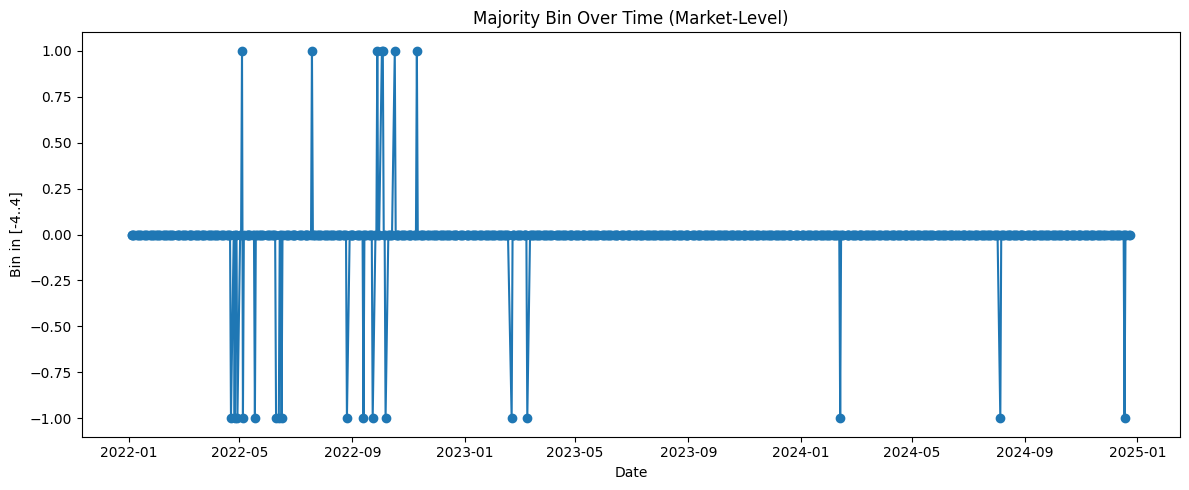

In [5]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

def bin_return(z):
    """
    Given a z-score, return an integer in [-4..4].
    Boundaries can be adjusted to your liking.
    """
    if z < -3.5:
        return -4
    elif z < -2.5:
        return -3
    elif z < -1.5:
        return -2
    elif z < -0.5:
        return -1
    elif z < 0.5:
        return 0
    elif z < 1.5:
        return 1
    elif z < 2.5:
        return 2
    elif z < 3.5:
        return 3
    else:
        return 4

def main_multi_state_analysis(data_path='Data/PriceData'):
    """
    1. Load all Parquet files (stock data).
    2. For each trading day, compute cross-section stdev of daily returns across all stocks.
    3. Bin each stock's daily return into -4..+4 based on that stdev.
    4. Identify the 'majority bin' across the market each day.
    5. Compute how often each stock matches that daily majority bin.
    """
    # 1) Load all parquet files into a single DataFrame with columns:
    #    ['Date', 'Symbol', 'Close'] (or more columns, but we'll focus on 'Close')
    
    parquet_files = glob.glob(os.path.join(data_path, '*.parquet'))
    all_data = []
    
    for file in tqdm(parquet_files, desc="Loading parquet files"):
        symbol = os.path.basename(file).replace('.parquet', '')
        try:
            df = pd.read_parquet(file, columns=['Date','Close'])
            df['Symbol'] = symbol
            all_data.append(df)
        except Exception as e:
            print(f"Error reading {symbol}: {e}")
    
    if not all_data:
        print("No data loaded. Exiting.")
        return
    
    df_all = pd.concat(all_data, ignore_index=True)
    df_all['Date'] = pd.to_datetime(df_all['Date'])
    # Sort so we have chronological order
    df_all = df_all.sort_values(['Date','Symbol']).reset_index(drop=True)
    
    # 2) Compute daily returns. We'll do groupby on Symbol first, then shift.
    #    We assume 1 row per day per symbol.
    df_all['DailyReturn'] = df_all.groupby('Symbol')['Close'].pct_change()
    
    # Now we have a big table with columns: [Date, Symbol, Close, DailyReturn]
    # Some rows may have NaN returns (first row for each symbol), so let's skip them for binning.
    df_all = df_all.dropna(subset=['DailyReturn'])
    
    # 3) For each Date, we want to compute cross-section stdev across all stocks
    #    that have data for that date. Then bin each stock's daily return.
    
    # We'll do this by grouping by Date, then applying a custom function.
    
    def process_group(g):
        # g is a subset for one Date, multiple symbols
        # cross-section stdev:
        stdev = g['DailyReturn'].std()
        # if stdev is 0 or nan, let's keep bins as 0 for all
        if pd.isna(stdev) or stdev == 0:
            g['State'] = 0
            return g
        
        # bin each daily return
        g['Z'] = g['DailyReturn'] / stdev
        g['State'] = g['Z'].apply(bin_return)
        return g
    
    df_all = df_all.groupby('Date', group_keys=False).apply(process_group)
    
    # Now df_all has a new column 'State' in [-4..4].
    # 4) Identify 'majority bin' for each day across the entire market:
    
    def find_majority_state(g):
        # g is all rows for one Date
        counts = g['State'].value_counts()
        majority_bin = counts.idxmax()  # the bin with highest count
        g['MarketBin'] = majority_bin
        return g
    
    df_all = df_all.groupby('Date', group_keys=False).apply(find_majority_state)
    
    # 5) For each row, see if 'State' == 'MarketBin'
    df_all['MatchesMarket'] = (df_all['State'] == df_all['MarketBin']).astype(int)
    
    # 6) Compute each stock's "market alignment" = fraction of days matched
    stock_alignment = (df_all.groupby('Symbol')['MatchesMarket']
                             .mean()
                             .sort_values(ascending=False))
    
    # 7) Outliers are the ones with the smallest fraction. 
    #    Let’s define a threshold or just see the distribution.
    
    # Example: Print top 10 and bottom 10 stocks
    print("Top 10 Stocks that match market pattern most often:")
    print(stock_alignment.head(10))
    print("\nBottom 10 Stocks that match market pattern least often:")
    print(stock_alignment.tail(10))
    
    # 8) Plot the distribution of market alignment
    plt.figure(figsize=(10, 5))
    plt.hist(stock_alignment.values, bins=30, alpha=0.7, edgecolor='k')
    plt.title("Distribution of Market Alignment Scores")
    plt.xlabel("Alignment Score (fraction of days matching the market bin)")
    plt.ylabel("Number of Stocks")
    plt.tight_layout()
    plt.show()
    
    # 9) (Optional) We can also plot how the "MarketBin" itself evolves over time
    #    i.e., the day-by-day majority bin. 
    #    Let's define an average or median bin? Or we can just show the raw majority bin.
    
    daily_market_bin = df_all.groupby('Date')['MarketBin'].first().reset_index()  
    # (We use .first() because MarketBin is the same across that day's group.)
    
    plt.figure(figsize=(12, 5))
    plt.plot(daily_market_bin['Date'], daily_market_bin['MarketBin'], marker='o', linestyle='-')
    plt.title("Majority Bin Over Time (Market‐Level)")
    plt.xlabel("Date")
    plt.ylabel("Bin in [-4..4]")
    plt.tight_layout()
    plt.show()
    
    return df_all, stock_alignment


if __name__ == "__main__":
    df_with_states, stock_scores = main_multi_state_analysis(data_path='Data/PriceData')
